# DeepEyeNet-Image Captioning with key word reinforced

## Keyword Model Part

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import json
import os
import re
import pickle
from tqdm import tqdm
from collections import defaultdict
import nltk
import h5py
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing import sequence, image
from keras.models import Sequential, Model, Input
from keras.layers import LSTM, Embedding, Concatenate, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Add, Lambda, Dot
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.models import load_model
import h5py

from model.model import CaptionModel
from model.model_k import AttentionModel, EncoderModel, MeanModel
from utils import *
from eval_tools import Cider, Rouge

Using TensorFlow backend.


# Load Data

In [2]:
# train_imgs, val_imgs, test_imgs
train_imgs = load_pickle('./data/data_path/train_imgs.pkl')
val_imgs = load_pickle('./data/data_path/val_imgs.pkl')
test_imgs = load_pickle('./data/data_path/test_imgs.pkl')

# Load pretrained img features
# vgg (224, 4096), vgg19 (224, 4096), inceptionV3 (299, 2048), resnet50 (224, 2048)
select_model = 'vgg'
img_size = 224
feat_size = 4096
train_imgs_features = load_pickle('./data/img_features/train_imgs_features_{}_sub.pkl'.format(select_model))
val_imgs_features = load_pickle('./data/img_features/val_imgs_features_{}_sub.pkl'.format(select_model))
test_imgs_features = load_pickle('./data/img_features/test_imgs_features_{}_sub.pkl'.format(select_model))

# Important features
results = load_pickle('./data/data_path/results.pkl')
keyword_results_path = 'results/results_keywords.pkl'

# Model Path
attention_path = './checkpoints/model_{}_new_keywords_attention.h5'.format(select_model)
encoder_path = './checkpoints/model_{}_new_keywords_encoder.h5'.format(select_model)
mean_path = './checkpoints/model_{}_new_keywords_mean.h5'.format(select_model)

# Model Name
model_names = ['attention', 'encoder', 'mean']
seq = ('test_gts_list', 'test_res_list', 'test_avgscore_list')

In [3]:
names = results["name"]
keywords = results["keywords"]
descriptions = results["descriptions"]
cap_toks = results["cap_toks"]
cap_ids = results["cap_ids"]
word2id = results["word2id"]
id2word = results["id2word"]
word2id_keys = results["word2id_keys"]
keywords_ids = results["keywords_ids"]

In [4]:
# Parameters
vocab_size = len(word2id)
max_len = max([len(x) for x in cap_toks.values()])
embedding_size = 300
new_vocab_size = len(word2id_keys)
key_max_len = max([len(x) for x in keywords_ids.values()])
steps_per_epoch = sum([len(cap_toks[img])-1 for img in train_imgs])

param = {}
param["key_max_len"] = key_max_len
param["keywords_ids"] = results['keywords_ids']
param["embedding_size"] = embedding_size
param["vocab_size"] = new_vocab_size
param["max_len"] = max_len
param["word2id"] = results["word2id"]
param["id2word"] = results["id2word"]
dic = load_pickle(keyword_results_path)

In [5]:
# 1. First approach: image-driven attention model for keyword embedding
model_obj_a = AttentionModel(param, feat_size)
final_model_a = model_obj_a.forward()

# 2. RNN-Encoder for keyword embedding
model_obj_r = EncoderModel(param, feat_size)
final_model_r = model_obj_r.forward()

# 3. RNN-Encoder for keyword embedding
model_obj_k = MeanModel(param, feat_size)
final_model_k = model_obj_k.forward()

# Build the New Keyword Model

Here we would like to build some new keyword embedded model to test the performances.

In [6]:
# Load Glove vectors
embeddings_index = {}
with open('./word_embedding/glove.6B.300d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
# Get 200-dim dense vector
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word2id.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
save_pickle(embedding_matrix, './data/data_path/embeddings.pkl')

## Training

In [9]:
def train(model_obj, model, model_path, load=True):
    if load and os.path.exists(model_path):
        model = load_model(model_path)
        return model
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    model.fit_generator(model_obj.data_generator_k(train_imgs_features, train_imgs, cap_ids, batch_size = 64), 
                        steps_per_epoch=steps_per_epoch, epochs=1)
    model.save(model_path)
    
    return model

## 1. Attention Model

In [13]:
final_model_a = train(model_obj_a, final_model_a, attention_path)

Epoch 1/1
16869/16869 [==============================] - 2441s 145ms/step - loss: 1.7947 - acc: 0.5819


In [8]:
final_model_a = train(model_obj_a, final_model_a, attention_path)

Epoch 1/1
16869/16869 [==============================] - 2409s 143ms/step - loss: 0.5904 - acc: 0.8459


In [11]:
final_model_a = train(model_obj_a, final_model_a, attention_path)

Epoch 1/1
16869/16869 [==============================] - 2518s 149ms/step - loss: 0.3439 - acc: 0.9085


In [23]:
final_model_a.save(attention_path)

## 2. Encoder Model

In [16]:
final_model_r = train(model_obj_r, final_model_r, encoder_path)

Epoch 1/1
16869/16869 [==============================] - 2698s 160ms/step - loss: 0.9606 - acc: 0.7776


In [10]:
final_model_r = train(model_obj_r, final_model_r,encoder_path)

Epoch 1/1
16869/16869 [==============================] - 2691s 160ms/step - loss: 0.2899 - acc: 0.9210


In [10]:
final_model_r = train(model_obj_r, final_model_r,encoder_path)

Epoch 1/1
16869/16869 [==============================] - 2685s 159ms/step - loss: 0.2245 - acc: 0.9375


In [13]:
final_model_r.save(encoder_path)

## 3. Mean Model

In [14]:
final_model_k = train(model_obj_k, final_model_k, mean_path)

Epoch 1/1
16869/16869 [==============================] - 2420s 143ms/step - loss: 0.7531 - acc: 0.8055


In [14]:
final_model_k = train(model_obj_k, final_model_k, mean_path)

Epoch 1/1
16869/16869 [==============================] - 2425s 144ms/step - loss: 0.4872 - acc: 0.8756


In [15]:
final_model_k.save(mean_path)

# Evaluation

In [ ]:
model_objs = [model_obj_a, model_obj_r, model_obj_k]
models = [final_model_a, final_model_r, final_model_k]
dic = {}.fromkeys(seq, list())

In [8]:
for model_obj, model, name in zip(model_objs, models, model_names):
    test_gts, test_res, test_avgscore = predict_captions(test_imgs, 
                                                         test_imgs_features, 
                                                         model, 
                                                         model_obj, 
                                                         results, 1, 0)
    dic['test_gts_list'] = dic['test_gts_list'] + [test_gts]
    dic['test_res_list'] = dic['test_res_list'] + [test_res]
    dic['test_avgscore_list'] = dic['test_avgscore_list'] + [test_avgscore]

196it [02:11,  1.49it/s]
196it [03:24,  1.04s/it]
196it [04:26,  1.36s/it]


In [9]:
save_pickle(dic, keyword_results_path)

## A. BLEU Score

In [11]:
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for attention model with test imgs: {:.4f}".format(i,dic['test_avgscore_list'][0][i]))
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for encoder model with test imgs: {:.4f}".format(i,dic['test_avgscore_list'][1][i]))
print('-----------------')
for i in range(4):
    print("Average Bleu-{} score for mean model with test imgs: {:.4f}".format(i,dic['test_avgscore_list'][2][i]))
print('-----------------')

-----------------
Average Bleu-0 score for attention model with test imgs: 0.6740
Average Bleu-1 score for attention model with test imgs: 0.5579
Average Bleu-2 score for attention model with test imgs: 0.4094
Average Bleu-3 score for attention model with test imgs: 0.3661
-----------------
Average Bleu-0 score for encoder model with test imgs: 0.5947
Average Bleu-1 score for encoder model with test imgs: 0.4859
Average Bleu-2 score for encoder model with test imgs: 0.3463
Average Bleu-3 score for encoder model with test imgs: 0.3105
-----------------
Average Bleu-0 score for mean model with test imgs: 0.6187
Average Bleu-1 score for mean model with test imgs: 0.5021
Average Bleu-2 score for mean model with test imgs: 0.3607
Average Bleu-3 score for mean model with test imgs: 0.3124
-----------------


### Single Example

model:  attention
Predicted Caption: ischemic central retinal vein occlusion.
Ground Truth Caption: ischemic central retinal vein occlusion.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0
model:  encoder
Predicted Caption: ischemic central retinal vein occlusion.
Ground Truth Caption: ischemic central retinal vein occlusion.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0
model:  mean
Predicted Caption: ischemic central retinal vein occlusion.
Ground Truth Caption: ischemic central retinal vein occlusion.
Bleu Score 1: 1.0
Bleu Score 2: 1.0
Bleu Score 3: 1.0
Bleu Score 4: 1.0


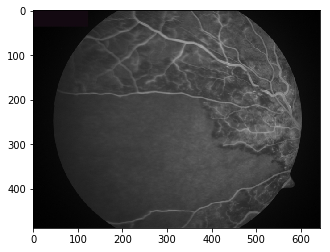

In [22]:
img_id = 142

for model_obj, model, name in zip(model_objs, models, names):
    print("\nmodel: ", name)
    im = predict_caption_bleu(img_id, train_imgs, train_imgs_features, model, model_obj, results, 1, 0)

plt.imshow(im)

## B. CIDEr, Rouge

In [5]:
calc_scores_k(Cider(), 'cider', model_names, dic)
calc_scores_k(Rouge(), 'rouge', model_names, dic)


-----------------------------
Evaluation:  cider
-----------------------------
attention:
test attention score = 3.9594
-----------------------------
encoder:
test encoder score = 3.2441
-----------------------------
mean:
test mean score = 3.4051

-----------------------------
Evaluation:  rouge
-----------------------------
attention:
test attention score = 0.6950
-----------------------------
encoder:
test encoder score = 0.6382
-----------------------------
mean:
test mean score = 0.6508
